# First Attemp to create a fault visualization in 3D

## Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import re
from bs4 import BeautifulSoup
import tifffile as tiff
from geotiff import GeoTiff
from folium.plugins import MousePosition
from mpl_toolkits.mplot3d import Axes3D

## Creating the map

In [2]:
i_coords = [-33.47, -70.655]
site_map = folium.Map(location=i_coords, zoom_start=10, tiles='Stamen Terrain')

Mouse positioning

In [3]:
formatter = "function(num) {return L.Util.formatNum(num, 5);};"
mouse_position = MousePosition(
    position='topright',
    separator=' Long: ',
    empty_string='NaN',
    lng_first=False,
    num_digits=20,
    prefix='Lat:',
    lat_formatter=formatter,
    lng_formatter=formatter,
)

site_map.add_child(mouse_position);

## Importing DEM

(<Figure size 988.8x604.8 with 2 Axes>,
 <AxesSubplot:>,
 <matplotlib.image.AxesImage at 0x25cea4a3880>)

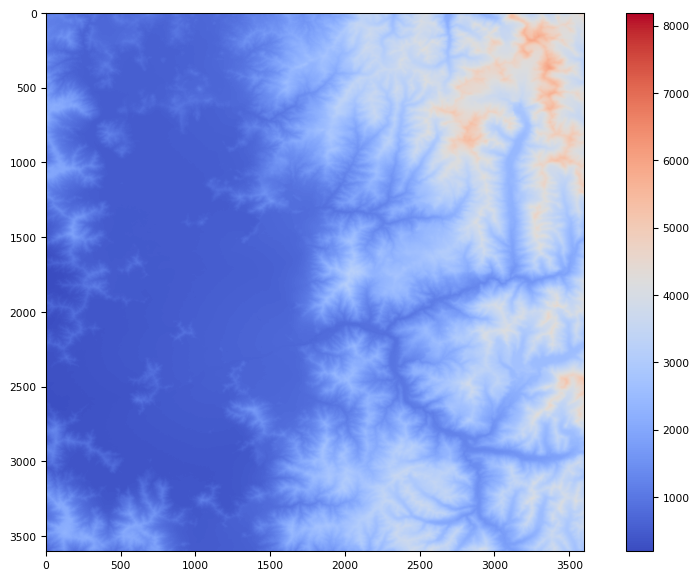

In [4]:
filename = 'DEM_Stgo.tif'
tfile = tiff.imread(filename)
tiff.imshow(tfile) # display the map

## Extracting Lat, Long and Elev from DEM

In [ ]:
tiff_file = 'DEM_Stgo.tif'
DEM = GeoTiff(tiff_file)
zar_array = GeoTiff.read(DEM)
elev = np.array(zar_array) 
lon_array, lat_array = DEM.get_coord_arrays()

In [ ]:
#Raster to xyz
lon = []; lat = []; z = []

for j in range(len(elev)):
    for i in range(len(elev)):
        lon.append(lon_array[j,i])
        lat.append(lat_array[j,i])
        z.append(elev[j,i])

## Creating a Dataframe

In [ ]:
if len(lon)==len(lat) & len(z)==len(lat):
    print ('Data OK!')
    print ('Creating dataframe')
    df = pd.DataFrame({'Latitud': lat, 'Longitud': lon, 'Elevation': z})
    df = df.astype('float')
    print ('Dataframe Created!')
else:
    print('Check Data')

In [7]:
# From DEM.txt
df = pd.read_csv('DEM.txt')
lat = df.Latitud
lon = df.Longitud
z = df.Elevation

### Add UTM datum

In [57]:
def coords_change(lon, lat, proj, zone):
    import pyproj
    import warnings
    warnings.filterwarnings("ignore", category=DeprecationWarning) 
    
    wgs84 = pyproj.Proj(proj='longlat', datum='WGS84')
    utm = pyproj.Proj(proj=proj, zone=zone, datum='WGS84')
    
    x, y = pyproj.transform(wgs84, utm, lon, lat)
        
    return x, y

In [58]:
change = coords_change(lon, lat, 'utm south', 19)
df['UTM_South'] = change[0]
df['UTM_West'] = change[1]

### Set point type to DEM

In [52]:
df['type'] = str('DEM')

### Save DF to txt

In [53]:
# Dataframe to txt file
df.to_csv('DEM.txt',sep=',',index=False)
print('txt file created!')

txt file created!


## Ploting Topography

### Extract and Drop some data to work 

In [ ]:
# work well untill 10^5*
def xyz(n):
    x = []; y = []; z = []
    index = np.linspace(0, len(df)-1, n, endpoint=True, dtype='int')
    for i in index:
        x.append(df['Latitud'][i])
        y.append(df['Longitud'][i])
        z.append(df['Elevation'][i])
    return x,y,z

In [ ]:
lat_m,lon_m,z_m=xyz(10**4)

### Scatter Plot

In [ ]:
def scatt_plot(x,y,z):
    %matplotlib widget
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(projection='3d')
    ax.scatter(x, y, z)
    plt.show()

In [ ]:
scatt_plot(lat,lon,z)

### Surface Plott

In [ ]:
%matplotlib widget
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
fig_=ax.plot_surface(lon_array, lat_array, elev, cmap='gist_earth')
plt.colorbar(fig_)
plt.show()

## Fault Trace

### Import Fault from KML

In [34]:
with open('FSR.kml','r') as file:
    data = file.read()
    
soup = BeautifulSoup (data)

coords = []
for t in soup.find_all('coordinates'):
        coords.append(t.get_text("|", strip=True))

C:\Users\vicen\anaconda3\lib\site-packages\bs4\builder\__init__.py:545: XMLParsedAsHTMLWarning: It looks like you're parsing an XML document using an HTML parser. If this really is an HTML document (maybe it's XHTML?), you can ignore or filter this warning. If it's XML, you should know that using an XML parser will be more reliable. To parse this document as XML, make sure you have the lxml package installed, and pass the keyword argument `features="xml"` into the BeautifulSoup constructor.
  warnings.warn(


In [35]:
lat_f = []; lon_f = []; trace = []

for i in range(len(coords)):
    a = coords[i].split(' ')
    for j in range(len(a)):
        b = a[j].split(',')
        lon_f.append(float(b[0]))
        lat_f.append(float(b[1]))
        trace.append(i)

In [36]:
df_fault = pd.DataFrame({'Latitud': lat_f, 'Longitud': lon_f, 'Elevation':np.zeros(len(lat_f)), 'type':'Fault', 
                         'trace':trace})

### Print Fault on the map

In [ ]:
for t in range(max(df_fault.trace)+1):
    fault_points = []
    df_trace = df_fault[df_fault.trace.eq(t)]
    
    for i in range(len(df_trace)):
        fault_points.append([df_trace.Latitud.iloc[i], df_trace.Longitud.iloc[i]])
        poly_fault = folium.PolyLine(locations=fault_points, color='black').add_to(site_map)

In [ ]:
site_map

### Set Fault Elevation

In [37]:
# Array of dem points
dem_points = np.c_[lat, lon, z]

# Array of fault points
fault_points = np.c_[lat_f, lon_f]

In [38]:
def distances_and_elevation (points, dem_points):
    min_dist = []
    elevations = []
    pnts = []
    dem_points_xy = np.array(dem_points)[:,:2]
    
    for p in points: 
        p = np.array(p)   
        d = np.sqrt(np.sum((dem_points_xy - p)**2, axis=1))
        min_dist.append(min(d))
        index = np.where(d == min(d))[0][0]
        elevations.append(dem_points[index][2])
        pnts.append(dem_points[index])
        
    return min_dist, elevations, pnts

In [39]:
md, elev_fault, points_selected = distances_and_elevation (fault_points, dem_points)

In [40]:
df_fault.Elevation = elev_fault

### Add UTM Datum

In [59]:
fault_change = coords_change(lon_f, lat_f, 'utm south', 19)
df_fault['UTM_South'] = fault_change[0]
df_fault['UTM_West'] = fault_change[1]

### Save to txt file

In [56]:
# Dataframe to txt file
df_fault.to_csv('fault_trace.txt',sep=',',index=False)
print('txt file created!')

txt file created!


### Project Fault in Depth

In [ ]:
from pyvista import examples
mesh = examples.download_st_helens()
warped = mesh.warp_by_scalar('Elevation')
surf = warped.extract_surface().triangulate()
surf = surf.decimate_pro(0.75)  # reduce the density of the mesh by 75%
surf.plot(cmap='gist_earth')

In [ ]:
import pyvista as pv

In [ ]:
fault_points